In [ ]:
import os
from tempfile import TemporaryDirectory
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
from tqdm import tqdm
import time
import pandas as pd
import shutil
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import Subset
from torch.optim import SGD, Adam
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

This projects aims to classify audio data of patients as either healthy, PD or parkinsonism cases. The original files are in wav form and were transformed to spectrograms. The code bellow makes use of ResNet50 with different configurations to try to assess the discriminative power of the model on the 3 classes of spectrograms. 

# Data handling

In [101]:
def split_data(src_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Splits the dataset into train, validation, and test sets.
    :param src_dir: Source directory containing the dataset.
    :param dest_dir: Destination directory where the split datasets will be saved.
    :param train_ratio: Proportion of the dataset to include in the train split.
    :param val_ratio: Proportion of the dataset to include in the validation split.
    :param test_ratio: Proportion of the dataset to include in the test split.
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    for class_name in os.listdir(src_dir):
        class_folder = os.path.join(src_dir, class_name)
        if not os.path.isdir(class_folder):
            continue

        files = os.listdir(class_folder)
        random.shuffle(files)

        total = len(files)
        train_end = int(total * train_ratio)
        val_end = train_end + int(total * val_ratio)

        subsets = {
            'train': files[:train_end],
            'val': files[train_end:val_end],
            'test': files[val_end:]
        }

        for subset, subset_files in subsets.items():
            subset_dir = os.path.join(dest_dir, subset, class_name)
            os.makedirs(subset_dir, exist_ok=True)
            for file in subset_files:
                shutil.copy(os.path.join(class_folder, file), os.path.join(subset_dir, file))


# Example usage
# split_data(r"pathofsourcefolder", r"pathofdestinationfolder")

data_dir = r'pathofdestinationfolder'

def transforms_(grayscale):
    """
    Returns a transform function for the dataset.
    :param grayscale: If True, converts images to grayscale.
    :return: A torchvision transforms.Compose object.
    """
    if grayscale:
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    else:
        return transforms.Compose([
                        transforms.Resize((224, 224)),             
                        transforms.ToTensor(),                        
                        transforms.Normalize(
                        mean=[0.485, 0.456, 0.406],             
                        std=[0.229, 0.224, 0.225]                
                            )
                        ])

# Model class

In [17]:
class SpectrogramResNet50(nn.Module):
    def __init__(self, num_classes=3, grayscale=True, freeze_backbone=False, freeze_until_layer=None, dropout = 0.4):
        """
        Parameters:
        - num_classes (int): Number of output classes.
        - grayscale (bool): If True, modifies the input layer for 1-channel input.
        - freeze_backbone (bool): If True, freezes the entire ResNet50 except the classifier.
        - freeze_until_layer (str): Name of layer to freeze up to 
        """
        super(SpectrogramResNet50, self).__init__()
        self.base_model = models.resnet50(pretrained=True)

        if grayscale:
            pretrained_weights = self.base_model.conv1.weight.data
            self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.base_model.conv1.weight.data = pretrained_weights.mean(dim=1, keepdim=True)

        if freeze_backbone:
            for param in self.base_model.parameters():
                param.requires_grad = False
                
        if freeze_until_layer is not None:
            freezing = True
            for name, child in self.base_model.named_children():
                if name == freeze_until_layer:
                    freezing = False
                for param in child.parameters():
                    param.requires_grad = not freezing

        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


training and testing function

In [33]:
# Adapted from: https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# Original author: Sasank Chilamkurthy, License: BSD
# Modified by Kristina Avramova
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=30):
    """
    Trains the model on the provided dataloaders.
    :param model: The model to train.
    :param dataloaders: Dictionary containing 'train' and 'val' DataLoader objects.
    :param dataset_sizes: Dictionary containing sizes of 'train' and 'val' datasets.
    :param criterion: Loss function.
    :param optimizer: Optimizer for training.   
    :param scheduler: Learning rate scheduler.
    :param num_epochs: Number of epochs to train.
    :return: The trained model.
    """
    best_acc = 0.0
    epochs_no_improve = 0

    with TemporaryDirectory() as tempdir:
        best_model_path = os.path.join(tempdir, 'best_model.pt')
        torch.save(model.state_dict(), best_model_path)

        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                model.train() if phase == 'train' else model.eval()
                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val':
                    if epoch_acc >= best_acc:
                        best_acc = epoch_acc
                        torch.save(model.state_dict(), best_model_path)
                        epochs_no_improve = 0
                    else:
                        epochs_no_improve += 1

        model.load_state_dict(torch.load(best_model_path))
        return model


## Stratified cross validation with different parameters

In [ ]:
def k_fold_cv(configs, k_folds=3, num_epochs=1):
    """
    Performs k-fold cross-validation on the dataset with the provided configurations.
    :param configs: List of dictionaries containing model configurations.
    :param k_folds: Number of folds for cross-validation.
    :param num_epochs: Number of epochs to train each model.
    :return: DataFrame containing the results of the cross-validation.
    """
    results = []
    
    for config_id, config in enumerate(configs):
        print(f"\n=== Running Config {config_id + 1}/{len(configs)}: {config} ===")
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
        val_accs = []
        transform = transforms(config['grayscale'])
        combined_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)

        X = list(range(len(combined_dataset)))
        y = combined_dataset.targets
            
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            print(f'\n---- Fold {fold + 1} ----')

            
            train_subset = Subset(combined_dataset, train_idx)
            val_subset = Subset(combined_dataset, val_idx)

            dataloaders_fold = {
                'train': DataLoader(train_subset, batch_size=config['batch_size'], shuffle=True, num_workers=8),
                'val': DataLoader(val_subset, batch_size=config['batch_size'], shuffle=False, num_workers=8)
            }
            dataset_sizes_fold = {
                'train': len(train_subset),
                'val': len(val_subset)
            }
            

            model = SpectrogramResNet50(
                num_classes=3,
                freeze_backbone=config['freeze_backbone'],
                freeze_until_layer=config['freeze_until_layer'],
                dropout=config['dropout'],
                grayscale=config['grayscale']
            ).to(device)

            criterion = nn.CrossEntropyLoss()
            
            if config['optimizer'] == 'SGD':
                optimizer = SGD(model.parameters(), lr=config['lr'], momentum=0.9)
            elif config['optimizer'] == 'Adam':
                optimizer = Adam(model.parameters(), lr=config['lr'])                

            scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
            model = train_model(model, dataloaders_fold, dataset_sizes_fold, criterion, optimizer, scheduler, num_epochs=num_epochs)

            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in dataloaders_fold['val']:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    correct += torch.sum(preds == labels).item()
                    total += labels.size(0)

            val_acc = correct / total
            print(f'Fold {fold + 1} Validation Accuracy: {val_acc:.4f}')
            val_accs.append(val_acc)

        mean_acc = np.mean(val_accs)
        std_acc = np.std(val_accs)
        print(f"\nConfig {config_id + 1} Mean Val Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

        result = dict(config)
        result.update({'mean_val_accuracy': mean_acc, 'std_val_accuracy': std_acc})
        results.append(result)

    df_results = pd.DataFrame(results)
    print("\nCross-validation Summary for all configs")
    print(df_results)
    return df_results


In [ ]:
# some of the tested configurations for the k-fold cross-validation, not all of them were used in this run
configs = [
    {'freeze_backbone': True, 'freeze_until_layer': None, 'batch_size': 8, 'lr': 0.001, 'dropout': 0.4, 'optimizer': 'SGD','grayscale':True},
    {'freeze_backbone': False, 'freeze_until_layer': 'layer2', 'batch_size': 16, 'lr': 0.0001, 'dropout': 0.6, 'optimizer': 'Adam','grayscale':True},
    {'freeze_backbone': False, 'freeze_until_layer': None, 'batch_size': 8, 'lr': 0.001, 'dropout': 0.4, 'optimizer': 'SGD','grayscale':True},
    {'freeze_backbone': False, 'freeze_until_layer': None, 'batch_size': 8, 'lr': 0.001, 'dropout': 0.4, 'optimizer': 'SGD','grayscale':False}
]

# Run 10-fold cross-validation with the specified configurations
df_results = k_fold_cv(configs=configs, k_folds=10, num_epochs=25)



=== Running Config 1/4: {'freeze_backbone': True, 'freeze_until_layer': None, 'batch_size': 8, 'lr': 0.001, 'dropout': 0.4, 'optimizer': 'SGD', 'grayscale': True} ===

---- Fold 1 ----


c:\Users\user1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/25
----------
train Loss: 1.0770 Acc: 0.4455
val Loss: 1.0955 Acc: 0.4167

Epoch 2/25
----------
train Loss: 1.0490 Acc: 0.4645
val Loss: 1.0739 Acc: 0.4167

Epoch 3/25
----------
train Loss: 1.0270 Acc: 0.5118
val Loss: 1.0962 Acc: 0.4167

Epoch 4/25
----------
train Loss: 1.0525 Acc: 0.4360
val Loss: 1.0528 Acc: 0.4583

Epoch 5/25
----------
train Loss: 1.0035 Acc: 0.4834
val Loss: 1.0104 Acc: 0.5000

Epoch 6/25
----------
train Loss: 0.9880 Acc: 0.5308
val Loss: 1.0031 Acc: 0.4167

Epoch 7/25
----------
train Loss: 0.9626 Acc: 0.5118
val Loss: 0.9732 Acc: 0.5000

Epoch 8/25
----------
train Loss: 0.9444 Acc: 0.5687
val Loss: 0.9723 Acc: 0.4583

Epoch 9/25
----------
train Loss: 0.9346 Acc: 0.5545
val Loss: 0.9758 Acc: 0.4583

Epoch 10/25
----------
train Loss: 0.9545 Acc: 0.5213
val Loss: 0.9652 Acc: 0.4583

Epoch 11/25
----------
train Loss: 0.9005 Acc: 0.5735
val Loss: 0.9646 Acc: 0.4583

Epoch 12/25
----------
train Loss: 0.9309 Acc: 0.5498
val Loss: 0.9675 Acc: 0.5833



c:\Users\user1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/25
----------
train Loss: 1.0762 Acc: 0.3934
val Loss: 1.1751 Acc: 0.4167

Epoch 2/25
----------
train Loss: 0.8680 Acc: 0.5498
val Loss: 1.3997 Acc: 0.4167

Epoch 3/25
----------
train Loss: 0.6055 Acc: 0.8720
val Loss: 1.0973 Acc: 0.5000

Epoch 4/25
----------
train Loss: 0.3427 Acc: 0.9147
val Loss: 1.1711 Acc: 0.4583

Epoch 5/25
----------
train Loss: 0.2433 Acc: 0.9479
val Loss: 1.0946 Acc: 0.5833

Epoch 6/25
----------
train Loss: 0.1876 Acc: 0.9573
val Loss: 1.1291 Acc: 0.5000

Epoch 7/25
----------
train Loss: 0.1708 Acc: 0.9526
val Loss: 0.8872 Acc: 0.6250

Epoch 8/25
----------
train Loss: 0.1190 Acc: 0.9763
val Loss: 0.7708 Acc: 0.7500

Epoch 9/25
----------
train Loss: 0.1516 Acc: 0.9573
val Loss: 0.8094 Acc: 0.6667

Epoch 10/25
----------
train Loss: 0.0816 Acc: 0.9905
val Loss: 0.7633 Acc: 0.6667

Epoch 11/25
----------
train Loss: 0.0709 Acc: 0.9953
val Loss: 0.7316 Acc: 0.6250

Epoch 12/25
----------
train Loss: 0.0846 Acc: 0.9953
val Loss: 0.7205 Acc: 0.6250



c:\Users\user1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/25
----------
train Loss: 1.1034 Acc: 0.4076
val Loss: 1.0936 Acc: 0.4167

Epoch 2/25
----------
train Loss: 1.0120 Acc: 0.4692
val Loss: 1.0467 Acc: 0.4167

Epoch 3/25
----------
train Loss: 0.9379 Acc: 0.5355
val Loss: 1.0457 Acc: 0.5417

Epoch 4/25
----------
train Loss: 0.8195 Acc: 0.6398
val Loss: 0.9714 Acc: 0.5417

Epoch 5/25
----------
train Loss: 0.7429 Acc: 0.6635
val Loss: 0.8241 Acc: 0.6667

Epoch 6/25
----------
train Loss: 0.5915 Acc: 0.7109
val Loss: 1.0660 Acc: 0.5417

Epoch 7/25
----------
train Loss: 0.4469 Acc: 0.8152
val Loss: 0.6571 Acc: 0.8333

Epoch 8/25
----------
train Loss: 0.3532 Acc: 0.8863
val Loss: 0.6431 Acc: 0.7917

Epoch 9/25
----------
train Loss: 0.3355 Acc: 0.9242
val Loss: 0.6492 Acc: 0.7917

Epoch 10/25
----------
train Loss: 0.2856 Acc: 0.9384
val Loss: 0.6612 Acc: 0.7083

Epoch 11/25
----------
train Loss: 0.2843 Acc: 0.9573
val Loss: 0.6736 Acc: 0.7083

Epoch 12/25
----------
train Loss: 0.3014 Acc: 0.9289
val Loss: 0.5927 Acc: 0.8333



c:\Users\user1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/25
----------
train Loss: 1.0878 Acc: 0.4265
val Loss: 1.0703 Acc: 0.4167

Epoch 2/25
----------
train Loss: 1.0190 Acc: 0.4692
val Loss: 1.0613 Acc: 0.4167

Epoch 3/25
----------
train Loss: 0.9301 Acc: 0.5355
val Loss: 1.0056 Acc: 0.5833

Epoch 4/25
----------
train Loss: 0.7809 Acc: 0.6635
val Loss: 0.9165 Acc: 0.7083

Epoch 5/25
----------
train Loss: 0.5926 Acc: 0.7536
val Loss: 0.9323 Acc: 0.6250

Epoch 6/25
----------
train Loss: 0.5584 Acc: 0.7867
val Loss: 0.8750 Acc: 0.5833

Epoch 7/25
----------
train Loss: 0.4520 Acc: 0.8720
val Loss: 0.9838 Acc: 0.5000

Epoch 8/25
----------
train Loss: 0.2802 Acc: 0.9336
val Loss: 0.7264 Acc: 0.7917

Epoch 9/25
----------
train Loss: 0.2127 Acc: 0.9905
val Loss: 0.7055 Acc: 0.7083

Epoch 10/25
----------
train Loss: 0.2422 Acc: 0.9621
val Loss: 0.6805 Acc: 0.8333

Epoch 11/25
----------
train Loss: 0.2526 Acc: 0.9431
val Loss: 0.7130 Acc: 0.7917

Epoch 12/25
----------
train Loss: 0.1892 Acc: 0.9668
val Loss: 0.6923 Acc: 0.7917



In [9]:
configs = [
    {'freeze_backbone': False, 'freeze_until_layer': 'layer2', 'batch_size': 8, 'lr': 0.001, 'dropout': 0.4, 'optimizer': 'SGD','grayscale':True}
]
df_results = k_fold_cv(configs=configs, k_folds=10, num_epochs=25)


=== Running Config 1/1: {'freeze_backbone': False, 'freeze_until_layer': 'layer2', 'batch_size': 8, 'lr': 0.001, 'dropout': 0.4, 'optimizer': 'SGD', 'grayscale': True} ===

---- Fold 1 ----


c:\Users\user1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/25
----------
train Loss: 1.0742 Acc: 0.4597
val Loss: 1.0810 Acc: 0.4167

Epoch 2/25
----------
train Loss: 1.0203 Acc: 0.4882
val Loss: 1.0447 Acc: 0.4167

Epoch 3/25
----------
train Loss: 0.9456 Acc: 0.4882
val Loss: 1.0006 Acc: 0.5417

Epoch 4/25
----------
train Loss: 0.8219 Acc: 0.6256
val Loss: 0.8887 Acc: 0.6250

Epoch 5/25
----------
train Loss: 0.6179 Acc: 0.7820
val Loss: 0.7783 Acc: 0.6667

Epoch 6/25
----------
train Loss: 0.4209 Acc: 0.9005
val Loss: 0.7831 Acc: 0.6667

Epoch 7/25
----------
train Loss: 0.2258 Acc: 0.9716
val Loss: 0.6799 Acc: 0.6250

Epoch 8/25
----------
train Loss: 0.1729 Acc: 0.9763
val Loss: 0.6987 Acc: 0.7083

Epoch 9/25
----------
train Loss: 0.1401 Acc: 0.9810
val Loss: 0.6415 Acc: 0.7500

Epoch 10/25
----------
train Loss: 0.1528 Acc: 0.9668
val Loss: 0.6971 Acc: 0.6667

Epoch 11/25
----------
train Loss: 0.1091 Acc: 0.9858
val Loss: 0.6797 Acc: 0.7500

Epoch 12/25
----------
train Loss: 0.0859 Acc: 1.0000
val Loss: 0.6441 Acc: 0.7917



### Results from cv


In [ ]:
# manual collection of some of the tested configuarions and results
df_results = pd.DataFrame({
    'freeze_backbone': [True, False, False, False,False],
    'freeze_until_layer': [None, 'layer2', None, None,'layer2'],
    'batch_size': [8, 16, 8, 8, 8],
    'lr': [0.001, 0.0001, 0.001, 0.001, 0.001],
    'dropout': [0.4, 0.6, 0.4, 0.4, 0.4],
    'optimizer': ['SGD', 'Adam', 'SGD', 'SGD', 'SGD'],
    'grayscale': [True, True, True, False, True],
    'mean_val_accuracy': [0.561232, 0.766667, 0.731703, 0.744928, 0.714674],
    'std_val_accuracy': [0.065892, 0.090369, 0.066624, 0.082906, 0.114913]
})

df_results

,freeze_backbone,freeze_until_layer,batch_size,lr,dropout,optimizer,grayscale,mean_val_accuracy,std_val_accuracy
0,True,None,8,0.0010,0.4,SGD,True,0.561232,0.065892
1,False,layer2,16,0.0001,0.6,Adam,True,0.766667,0.090369
2,False,None,8,0.0010,0.4,SGD,True,0.731703,0.066624
3,False,None,8,0.0010,0.4,SGD,False,0.744928,0.082906
4,False,layer2,8,0.0010,0.4,SGD,True,0.714674,0.114913


obtained best configuration: {'freeze_backbone': False, 'freeze_until_layer': 'layer2', 'batch_size': 16, 'lr': 0.0001, 'dropout': 0.6, 'optimizer': 'Adam','grayscale':True}

To note: there is lack of data about statistical valdity of the obtained differences in means.

Retraining model with best configuration. 

In [ ]:
# retraining model with best configuration
best_config = {'freeze_backbone': False, 'freeze_until_layer': 'layer2', 'batch_size': 16, 'lr': 0.0001, 'dropout': 0.6, 'optimizer': 'Adam','grayscale':True}
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transforms_(best_config['grayscale']))
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transforms_(best_config['grayscale']))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

model = SpectrogramResNet50(
    num_classes=3,
    freeze_backbone=False,
    freeze_until_layer='layer2',
    dropout=0.6,
    grayscale=True
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters() ,lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25)

c:\Users\user1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/25
----------
train Loss: 1.0307 Acc: 0.4511
val Loss: 1.0435 Acc: 0.4694

Epoch 2/25
----------
train Loss: 0.7175 Acc: 0.7149
val Loss: 0.7030 Acc: 0.6531

Epoch 3/25
----------
train Loss: 0.4729 Acc: 0.8340
val Loss: 0.8268 Acc: 0.5918

Epoch 4/25
----------
train Loss: 0.4035 Acc: 0.8383
val Loss: 0.6198 Acc: 0.7143

Epoch 5/25
----------
train Loss: 0.3144 Acc: 0.8723
val Loss: 1.0010 Acc: 0.6327

Epoch 6/25
----------
train Loss: 0.2783 Acc: 0.8979
val Loss: 0.7407 Acc: 0.6531

Epoch 7/25
----------
train Loss: 0.2157 Acc: 0.9106
val Loss: 0.7544 Acc: 0.7551

Epoch 8/25
----------
train Loss: 0.1590 Acc: 0.9532
val Loss: 0.6818 Acc: 0.7143

Epoch 9/25
----------
train Loss: 0.0932 Acc: 0.9830
val Loss: 0.7343 Acc: 0.6939

Epoch 10/25
----------
train Loss: 0.0879 Acc: 0.9787
val Loss: 0.7202 Acc: 0.7347

Epoch 11/25
----------
train Loss: 0.1470 Acc: 0.9489
val Loss: 0.6714 Acc: 0.7755

Epoch 12/25
----------
train Loss: 0.0750 Acc: 0.9957
val Loss: 0.6835 Acc: 0.7551



In [ ]:
# saving model
path = r''
torch.save(model.state_dict(),path)

# Evaluation

In [ ]:
# testing model on the test set
test = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transforms_(True))
test_loader = DataLoader(test, batch_size=8, shuffle=True, num_workers=4)
class_names = test.classes

In [ ]:
model.to(device)
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [91]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           h       0.75      0.86      0.80        14
parkinsonism       0.92      0.92      0.92        24
          pd       0.85      0.73      0.79        15

    accuracy                           0.85        53
   macro avg       0.84      0.84      0.83        53
weighted avg       0.85      0.85      0.85        53



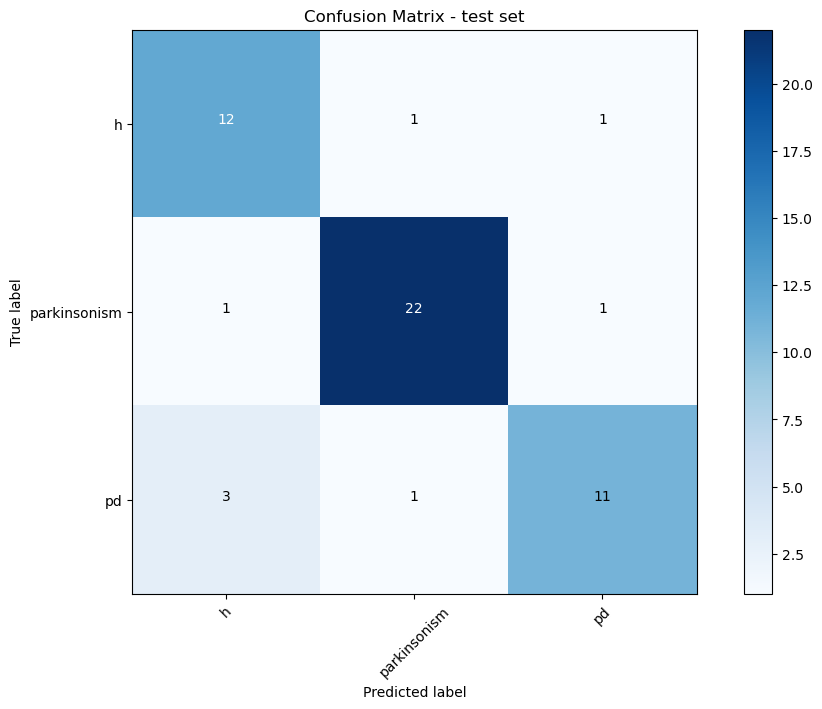

In [93]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - test set')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Model obtained accuracy of 85% on the test set. Validation accuracy was 77.5%. The mean accuracy of this configuration for the 10 fold cross validation on the train set was about 77% with a standard deviation of about 9% (original values are multiplied by 100). Performance seems very high however it is likely due to chance. More testing required

Future steps such as **benchmarking and statistical validity testing** would be of value. 

In [82]:
# A final check to ensure no duplicates in the test set and no data leakage from the training set
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train = []
test= []
for root, _, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('png', 'jpg', 'jpeg')):
            train.append(file)

for root, _, files in os.walk(test_dir):
    for file in files:
        if file.lower().endswith(('png', 'jpg', 'jpeg')):
            test.append(file)

In [ ]:
set(train).intersection(set(test))
# empty set, no duplicates found

set()